In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Query NVE's Grid Time Series (GTS) API

NVE has an open API for querying time series from their **1 km resolution gridded historic weather dataset**. The API is documented [here](http://api.nve.no/doc/gridtimeseries-data-gts/) and provides data from 1957 to present.

For a wide range of weather and hydrological parameters, and for any location in Norway, it is possible to query:

 1. Time series for specific points (i.e. values over time for a specific grid cell), and 
 
 2. Spatially aggregated time series for a user-defined area (i.e. the user supplies a polygon and the API returns grid-averaged values for the polygon for each time point)
 
NivaPy's "data access" (`.da`) module includes functions to make it easier to query data via this API. 

## Get time series for points (i.e. specific grid cells)

### Example data

As a starting point, the user must supply a dataframe listing the locations of interest. The dataframe must include columns for the x and y co-ordinates, plus a column with a unique identifier for each location (in other words, each row of the dataframe should have a unique identifier).

Data can be provided in any co-ordinate system you wish, but if the co-ordinates are not WGS84-based lat/lon (the default), you **must remember to explicitly specify the CRS**. The API requires co-ordinates in UTM Zone 33N, so whatever data you provide will first be reprojected to this CRS before submitting the query. This is handled automatically, *as long as you specify the original CRS correctly* (see below).

In [4]:
# Read example data from Finnmark
csv_path = "../data/outlet_coordinates/for_met_data.csv"
df = pd.read_csv(csv_path, sep=",")
df.head()

,site_ID,site_name,outlet_lat,outlet_lon
0,14,Cearrogeasjohka,69.389922,24.472635


### List all available parameters

Get a list of all parameters available via the API.

Note that a `TimeResolutionInMinutes` of 1440 corresponds to **daily** data.

In [2]:
par_df = nivapy.da.get_nve_gts_api_parameters()
par_df

,Name,Fullname,NoDataValue,RawUnit,HumanReadableUnit,TimeResolutionInMinutes,FirstDateInTimeSerie
0,rr,Døgnnedbør v2.0,65535,mm,mm,1440,1957-01-01
1,tm,Døgntemperatur v2.0,65535,Kelvin,Celcius,1440,1957-01-01
4,swe,Snømengde v2.0.1,65535,mm,mm,1440,1957-01-01
5,snowload,Snølast,65535,kg/m2,kg/m2,1440,2000-01-01
6,sd,Snødybde v2.0.1,65535,mm,cm,1440,1957-01-01
7,swepr,Snømengde i prosent v2.0.1,65535,%,%,1440,1957-01-01
8,age,Snøens alder v2.0.1,255,Dager,Dager,1440,1957-01-01
9,qtt,Regn og snøsmelting v2.0.1,255,mm,mm,1440,1957-01-01
10,qtt7d,Regn og snøsmelting siste uke,65535,mm,mm,1440,1957-01-01
11,gwb_q,Avrenning,65535,mm,mm,1440,1957-01-01


### Get time series

Choose the parameters of interest from `par_df` above, then pass this to `nivapy.da.get_nve_gts_api_time_series()` along with your dataframe of target locations. Parameters can either be specified as a list (as in the example below), or a filtered dataframe in the same format as `par_df` above. You must also specify your time period of interest.

In [4]:
pars = ["rr", "tm"]
# pars = par_df.query("Name in ['rr', 'tm']") # Sometimes it's useful to pass filtered 'par_df' instead

st_dt = "2010-01-01"
end_dt = "2020-12-31"

res_df = nivapy.da.get_nve_gts_api_time_series(
    df,
    pars,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)
res_df.head()

Looping over parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/21 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/21 [00:00<?, ?it/s]

,site_id,x_utm_33n,y_utm_33n,altitude_m,par,full_name,unit,time_resolution,datetime,value
0,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-01 06:00:00,0.8
1,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-02 06:00:00,0.4
2,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-03 06:00:00,1.3
3,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-04 06:00:00,0.7
4,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-05 06:00:00,0.1


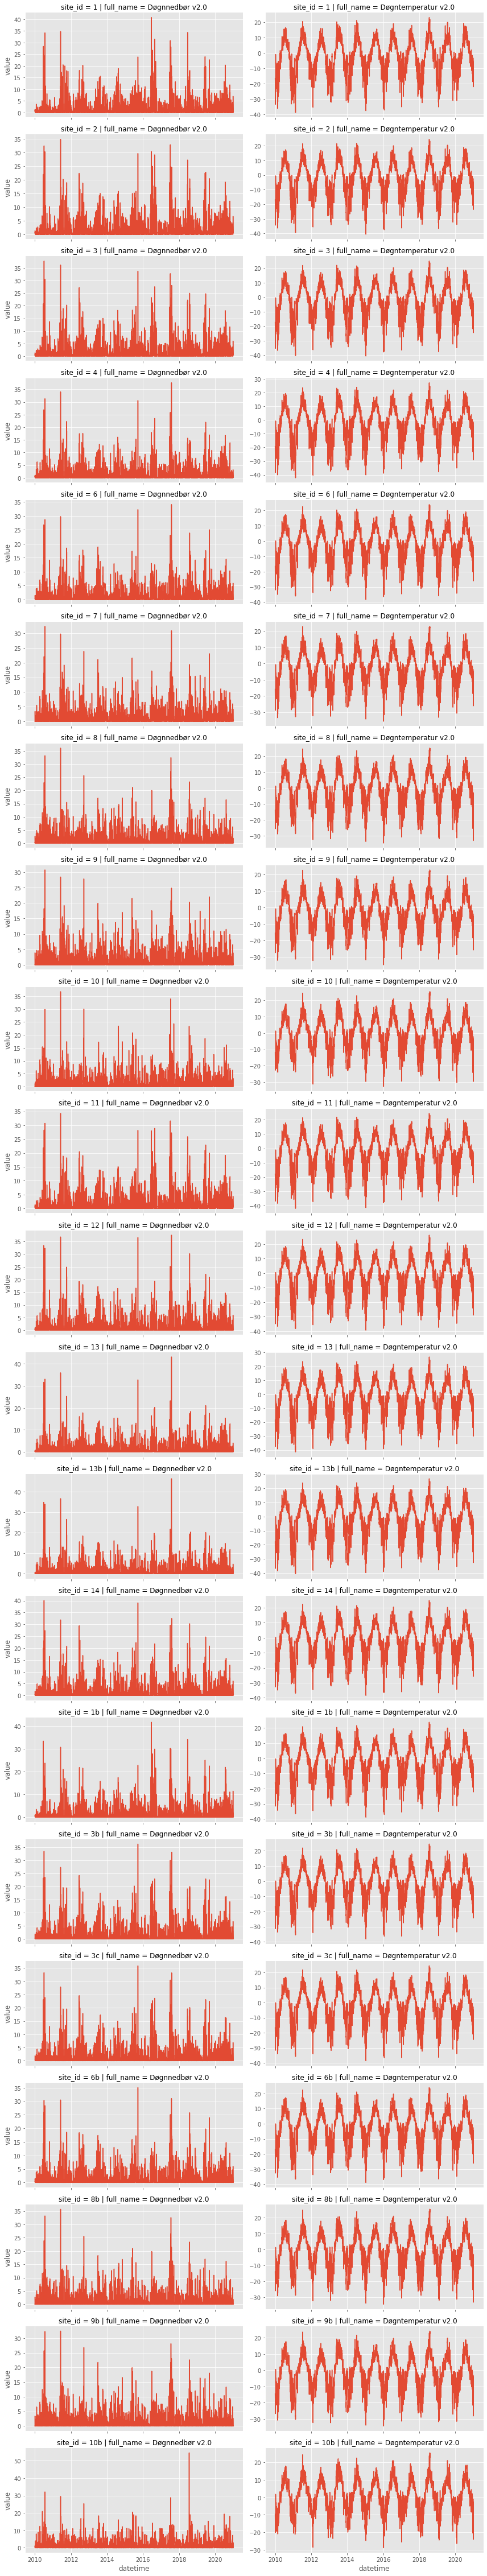

In [5]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y="value",
    col="full_name",
    row="site_id",
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)

## 2. Get time series for polygons (i.e. aggregate multiple grid cells)

**Note:** The GTS API has a dedicated endpoint for spatially aggregated queries, but this doesn't seem to be working at present. I have contacted NVE about this, but haven't had a reply yet. To work around this issue, the current implementation for spatially aggregated queries in NivaPy is a little inefficient, as it involves querying the API many more times than should be necessary. Nevertheless, it is still much faster than e.g. downloading NGCD data from Thredds.

### 2.1. Example data

The user must supply a geodataframe containing the polygons of interest. This could be read e.g. from a shapefile or from GeoJSON. Each row of the dataframe should represent one area of interest (use a [spatial dissolve](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) operation first if necessary) and there must be a column containing a unique identifier for each polygon.

The example here uses a geodataframe containing catchment boundaries for 21 small catchments in Finnmark.

In [6]:
# Example catchments in Finnmark
shp_path = r"../example_data/catchment_boundaries_2021.shp"
gdf = gpd.read_file(shp_path)
gdf.head()

,vassdragNr,areal_km2,site_name,site_id,geometry
0,234.GEB,9.40,Njahkajavri,1,"POLYGON ((850817.528 7669267.751, 851025.000 7..."
1,234.J3A0,84.26,Caskin-jeaggi / Caskinjohka,4,"POLYGON ((914016.660 7689380.680, 914222.460 7..."
2,234.GDAZ,41.24,Juovvajohka,3,"POLYGON ((870050.000 7694700.000, 870081.269 7..."
3,234.F3BZ,27.38,Gurrojohka,9,"POLYGON ((919269.498 7802100.122, 919364.457 7..."
4,234.GEA0,24.86,Vuomajeaggi,2,"POLYGON ((864315.450 7683072.205, 864387.977 7..."


### 2.2. Get aggregated time series

If necessary, first use `nivapy.da.get_nve_gts_api_parameters()` to find your parameters of interest (see section 1.3, above). Then use `nivapy.da.get_nve_gts_api_aggregated_time_series()` to download averaged data for each unique area in you input geodataframe.

**Be sure that the CRS of the geodataframe is set correctly before querying the API**.

For each polygon-parameter-timestamp combination, the function returns the minimum, median, maximum, mean, standard deviation and count of grid cell values within the polygon. Note in particular that `value_count` is the number of 1 km x 1 km cell centres located within each polygon. The sum of values in a polygon can therefore be easily estimated as `count * mean`. The `count` column is also an approximate measure of the size of each polygon in square kilometres (i.e. the area when discretised into a 1 km grid).

In [7]:
pars = ["rr", "tm"]
st_dt = "2010-01-01"
end_dt = "2020-12-31"

res_df = nivapy.da.get_nve_gts_api_aggregated_time_series(
    gdf,
    pars,
    st_dt,
    end_dt,
    id_col="site_id",
)
res_df.head()

Looping over parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/747 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/747 [00:00<?, ?it/s]

,site_id,par,datetime,mean_altitude_m,full_name,unit,time_resolution,value_min,value_median,value_max,value_mean,value_std,value_count
0,1,rr,2010-01-01 06:00:00,524.125,Døgnnedbør v2.0,mm,1440,0.7,0.7,0.8,0.725,0.046291,8
1,1,rr,2010-01-02 06:00:00,524.125,Døgnnedbør v2.0,mm,1440,0.4,0.4,0.4,0.400,0.000000,8
2,1,rr,2010-01-03 06:00:00,524.125,Døgnnedbør v2.0,mm,1440,1.2,1.3,1.3,1.275,0.046291,8
3,1,rr,2010-01-04 06:00:00,524.125,Døgnnedbør v2.0,mm,1440,0.7,0.7,0.7,0.700,0.000000,8
4,1,rr,2010-01-05 06:00:00,524.125,Døgnnedbør v2.0,mm,1440,0.1,0.1,0.1,0.100,0.000000,8


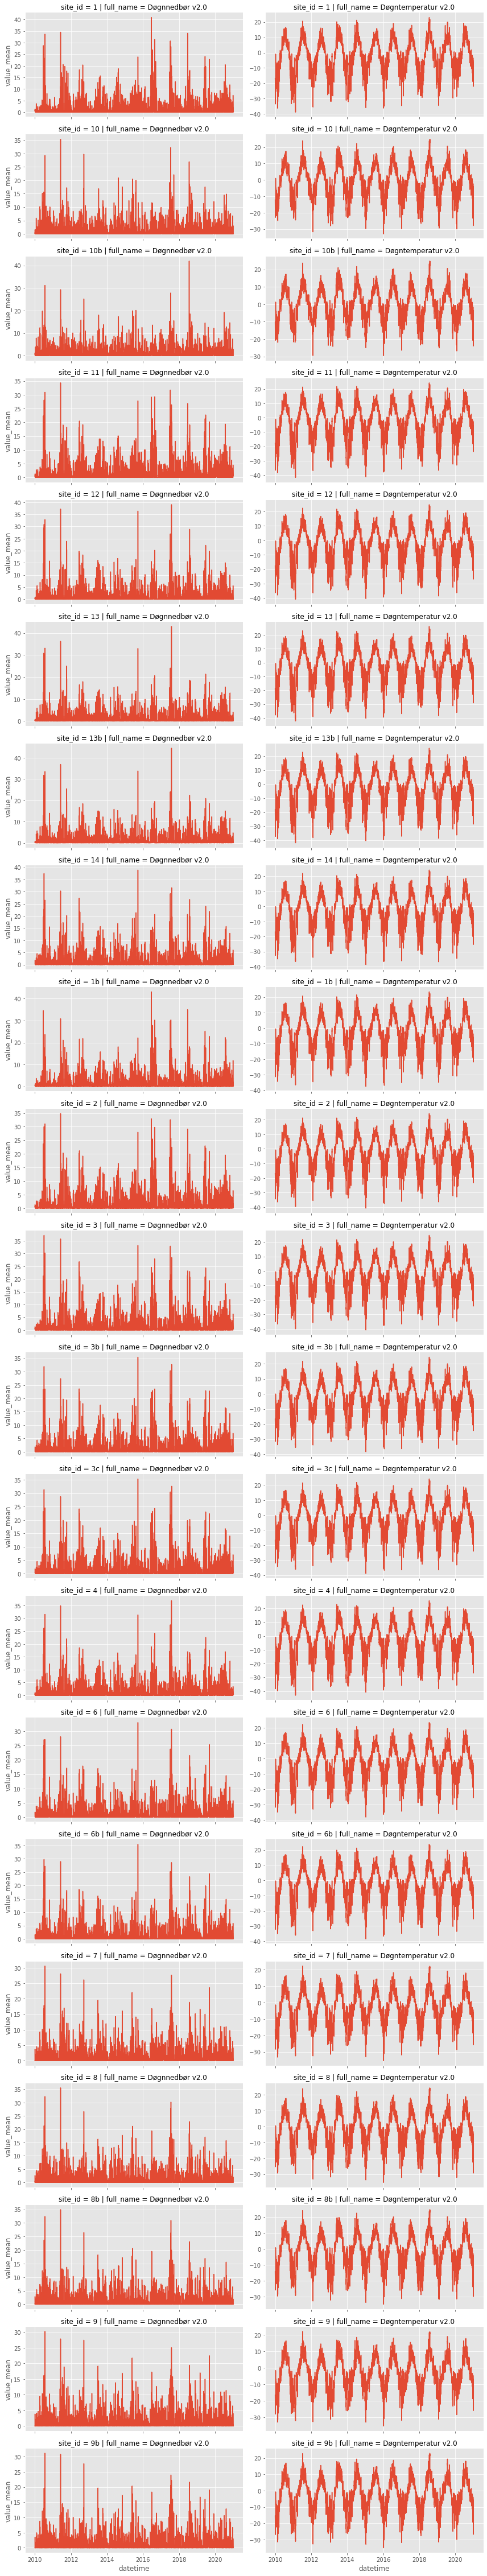

In [8]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y="value_mean",
    col="full_name",
    row="site_id",
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)